In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt

from nose.tools import *

#these imports are for Basemap - PROJ_LIB
import os
import conda

#this takes care of PROJ_LIB path variable (Basemap)
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

import networkx as nx
from networkx.algorithms import community
# Write your imports here

# Working with Spatial Data and Networks Lab
## Preparing data, extracting features, visualization and modelling

In this lab we'll explore terrorism, as described in [this](https://www.kaggle.com/START-UMD/gtd) dataset.

The full codebook, describing all variables, their values, the data collection process, and many more details, is located [here](http://start.umd.edu/gtd/downloads/Codebook.pdf).

We'll perform our usual process:
* Reading and inspecting the data
* Validating the data
* Exploring the data
* Creating inferences and getting to conclusions

### Problem 1. Read the dataset (1 point)
The dataset is provided in the `data` folder. Read it into Python. You'll likely get an encoding error, so you can use `encoding = "cp1252"`.

Use the column `eventid` as the index, since this is a good unique identifier and it's used in the dataset (e.g. the column `related` contains the `eventid` of all related crimes).

You'll see the dataset has a lot of columns. For this lab, we aren't going to need all of them, only a few. Select these columns (and rename them as described in the tests below):
* eventid
* iyear, imonth, iday
* country_txt
* region_txt
* multiple (1 if it's a part of a multiple incident and 0 otherwise)
* latitude, longitude
* targtype1_txt (first target type)
* weaptype1_text (weapon type)
* gname (perpetrator group name)
* nkill (total number of fatalities)
* related (IDs of the related incidents)

You'll have a total of 13 columns (the eventid which will become an index is not considered a typical column in a dataframe) and just over 170 thousand records.

In [3]:
terrorism_data = pd.read_csv('./DataSets/globalterrorismdb.csv', index_col='eventid',
                             encoding = "cp1252", low_memory = False)

#the two lines below allow us to see all the columns without truncation
#this allows us to see the dataset better
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#the dataset has 135 columns - creates list with all the column names
len(terrorism_data.columns.tolist())

#we can see the actual columns
terrorism_data.columns.tolist()

#taking only the columns we need to do the data analysis
terrorism_data = terrorism_data[['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'multiple',
                                 'latitude', 'longitude', 'targtype1_txt', 'weaptype1_txt', 'gname',
                                 'nkill', 'related']]

#we can change the column names using: 
#df.rename(columns={'old_col':'new_col', 'old_col_2':'new_col_2'}, inplace=True)
#but it will be time consuming and long, because we have to change the names of many columns
terrorism_data.columns = ['year', 'month', 'day', 'country', 'region', 'multiple',
                          'latitude', 'longitude', 'target_type', 'weapon_type',
                          'group_name', 'fatalities', 'related']

terrorism_data.head(3)
#terrorism_data.shape

,year,month,day,country,region,multiple,latitude,longitude,target_type,weapon_type,group_name,fatalities,related
eventid,,,,,,,,,,,,,
197000000001,1970,7,2,Dominican Republic,Central America & Caribbean,0,18.456792,-69.951164,Private Citizens & Property,Unknown,MANO-D,1.0,NaN
197000000002,1970,0,0,Mexico,North America,0,19.432608,-99.133207,Government (Diplomatic),Unknown,23rd of September Communist League,0.0,NaN
197001000001,1970,1,0,Philippines,Southeast Asia,0,15.478598,120.599741,Journalists & Media,Unknown,Unknown,1.0,NaN


In [4]:
assert_is_not_none(terrorism_data)
assert_list_equal(terrorism_data.columns.tolist(), ["year", "month", "day", "country", "region", "multiple", "latitude", "longitude", "target_type", "weapon_type", "group_name", "fatalities", "related"])

### Problem 2. Convert columns (1 point)
Convert the "year", "month" and "day" columns into a single date. Call the new column "date".

Note that some months and/or days contain 0 as their values. This means that the exact month or day is not present or known. In these cases, write "not a time" (NaT) values in the "date" column. Do not remove those records!

Also, convert the "multiple" column into a Boolean one.

In [5]:
#viewing the unique values of the columns - 'year', 'month' and 'day'
#we can see that column 'year' doesn't have 0 as value
terrorism_data['year'].unique(), terrorism_data['month'].unique(), terrorism_data['day'].unique()

#we can see that columns 'year', 'month' and 'day' are 'int' type, which is good, 
#but we need to merge them and create 'date' column so we need to convert them to 'str'
#and after the transformations we can convert columns 'year', 'month' and 'day' to 'int' type
terrorism_data.dtypes

#casting columns 'year', 'month' and 'day' to 'str'
terrorism_data[['year', 'month', 'day']] = terrorism_data[['year', 'month', 'day']].astype(str)

#confirming that 'year', 'month' and 'day' are 'str' type
terrorism_data.dtypes

#creating new column date from the 'str' columns  - '/' is the separator
terrorism_data['date'] = terrorism_data[['day', 'month', 'year']].agg('/'.join, axis=1)

#info for pd.to_datetime
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
#errors='coerce' - If ‘coerce’, then invalid parsing/row will be set as NaT (Not a Time)
#note it is not actually converting the dates into the given format
#this is a bug described in the pandas documentation, link is above
terrorism_data['date'] = pd.to_datetime(terrorism_data['date'], dayfirst = True,
                                        format = '%d/%m/%Y', errors = 'coerce')

#returning the columns 'year', 'month' and 'day' to 'int'
terrorism_data[['year', 'month', 'day']] = terrorism_data[['year', 'month', 'day']].astype(np.int64)

#converting 'multiple' column into 'bool'
#it can be written also:   astype(bool) ,    !!!!  astype(np.bool)   !!!!  gives DeprecationWarning  
#which mean that is it no longer used
terrorism_data['multiple'] = terrorism_data['multiple'].astype(np.bool_)

#columns 'year', 'month' and 'day' are 'int' and 'date' column is datetime
#column 'multiple' is cast to bool
terrorism_data.dtypes

#rearranging the columns
terrorism_data = terrorism_data[['date', 'day', 'month', 'year', 'country', 'region',
                                 'multiple', 'latitude', 'longitude', 'target_type',
                                 'weapon_type', 'group_name', 'fatalities', 'related']]

#terrorism_data.head(5)

#the DeprecationWarning from the checking cell below is fixed
#no warning pops up
assert_greater(len(terrorism_data.date), 0)
assert_equal(terrorism_data.multiple.dtype, np.bool_)
assert_equal(terrorism_data.multiple.dtype, bool)

In [6]:
assert_greater(len(terrorism_data.date), 0)
assert_equal(terrorism_data.multiple.dtype, np.bool)

<ipython-input-6-996fb6eba080>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert_equal(terrorism_data.multiple.dtype, np.bool)


### Problem 3. Show how the number of attacks evolves with time (1 point)
Group all incidents by year. Create a line plot showing how the attacks evolve.

Create a function which accepts a dataframe and returns the years with minimum and maximum incidents.

Use this function to see the numbers for your dataset.

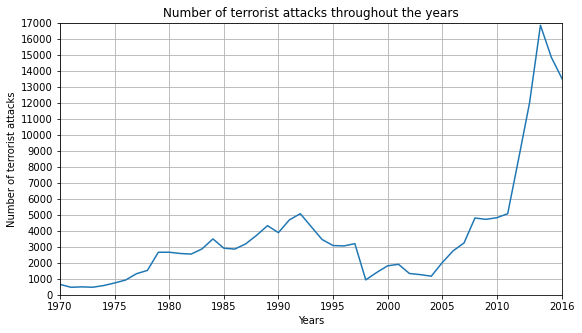

In [7]:
#we can see that the year span is from 1970 to 2016 - needed for the X axis
terrorism_data['year'].unique()

#we can see how many attacks there are for each year
#the year with the highest number of terrorist attacks is
#2014 with 16860 attacks - needed for the Y axis
attacks_by_year = terrorism_data.groupby('year').size()
attacks_by_year


#defining the size of the plot
plt.figure(figsize=(9,5))

#creating the line plot
plt.plot(attacks_by_year)

#title and labels
plt.title('Number of terrorist attacks throughout the years')
plt.xlabel('Years')
plt.ylabel('Number of terrorist attacks')

#changing the xticks
# array([1960., 1970., 1980., 1990., 2000., 2010., 2020.])
plt.xticks( list(range(1960, 2015, 5)) + [2016])

#changing the yticks
# array([-2500., 0., 2500., 5000., 7500., 10000., 12500., 15000., 17500., 20000.])
plt.yticks(list( range(0, 18000, 1000) ))

#shows only values between 1970 and 2016 on the X axis
plt.xlim(1970, 2016)

#shows only values between 0 and 17000 on the Y axis
plt.ylim(0, 17000)

plt.grid()
plt.show()

#we can clearly see that there are two peaks the first one between 1990 and 1995
#the second one is between 2010 and 2016, where we observe sharp increase in the terrorist attacks

In [8]:
def get_max_and_min_incidents_years(dataframe):
    """this function takes dataframe and returns the years 
    with minimum and maximum terrorist attacks"""
    
    #initiating the values we want to find out
    min_incidents_year, max_incidents_year = 0, 0
    
    #we create a dictionary from the Series we used before
    #first we instantiate the variable and the convert the Series into dictionary
    attacks_by_year_dictionary = dataframe.groupby('year').size()
    attacks_by_year_dictionary.to_dict
    
    #we instantiate two variable, which find the min and max values of the Series
    min_victim_number = min(list(dataframe.groupby('year').size()))
    max_victim_number = max(list(dataframe.groupby('year').size()))
    
    #dictionaries have 'keys' and 'values'
    #in this case the 'keys' are the dates and the 'values' are the number of terrorist attacks
    #we are looking for 'key' with for loop in all the 'keys' and 
    #if the min/max 'value' matches max/min_victim_number variable it returns the 'key'
    min_incidents_year = [key for key in attacks_by_year_dictionary.keys() if attacks_by_year_dictionary[key] == min_victim_number]
    max_incidents_year = [key for key in attacks_by_year_dictionary.keys() if attacks_by_year_dictionary[key] == max_victim_number]
    
    #because it returns generator and to see the value it needs to be in list brackets '[]'
    #we can access the only item in the list and reassign it to the same variable
    min_incidents_year = min_incidents_year[0]
    max_incidents_year = max_incidents_year[0]
    
    return (min_incidents_year, max_incidents_year)


#code that works outside of function - given for information
# attacks_by_year_dictionary = terrorism_data.groupby('year').size()
# attacks_by_year_dictionary.to_dict
# attacks_by_year_dictionary

# victim_number = min(list(terrorism_data.groupby('year').size()))

# year = [key for key in attacks_by_year_dictionary.keys() if attacks_by_year_dictionary[key] == victim_number]
# year

#sample keys and values - for checking if we need to
# 1978     1526
# 1979     2661
# 1980     2662
# 1981     2585
# 1982     2545
# 1983     2870
# 1984     3495
# 1985     2915
# 1986     2860
# 1987     3184

In [9]:
min_year, max_year = get_max_and_min_incidents_years(terrorism_data)
assert_equal(min_year, 1971)
assert_equal(max_year, 2014)

### Problem 4. Filter terror attacks (1 point)
Get only recent attacks (from 1 Jan 2000 onwards, inclusive). Save them in the variable `recent_attacks`.

Create another variable which contains attacks before that. Call that `older_attacks`.

We'll compare these later.

In [10]:
#size of the dataframe - (170350, 14)
terrorism_data.shape

#instantiating new dataframe using the criteria in the brackets - (100586, 14)
recent_attacks = terrorism_data[(terrorism_data['year'] >= 2000)]

#instantiating new dataframe using the criteria in the brackets - (69764, 14)
older_attacks = terrorism_data[(terrorism_data['year'] < 2000)]

#check to see if the sum of the 2 datasets is equal to the initial dataset
assert(terrorism_data.shape[0] == recent_attacks.shape[0] + older_attacks.shape[0])

In [11]:
assert_is_not_none(recent_attacks)
assert_is_not_none(older_attacks)

### Problem 5. Compare recent to older attacks (1 point)
Create a function which accepts a dataframe and returns a `Series`. The index should be a country name, and the values should be the number of  attacks. Sort the values from highest to lowest.

In [12]:
def get_num_attacks_by_country(dataframe):
    '''this function accepts dataframe and returns Series with country name as index
    and values sorted in descending order should be the number of attacks '''
    
    terrorist_attacks_by_country = dataframe.groupby('country').size().sort_values(ascending = False)

    return terrorist_attacks_by_country.head(10)

#this code works outside a function - given for information
# terrorist_attacks_by_country = terrorism_data.groupby('country').size().sort_values(ascending = False)
# terrorist_attacks_by_country
# isinstance(terrorist_attacks_by_country, pd.Series)

In [13]:
recent_attacks_by_country = get_num_attacks_by_country(recent_attacks)
older_attacks_by_country = get_num_attacks_by_country(older_attacks)
print(recent_attacks_by_country)
print(older_attacks_by_country)
assert_equal(recent_attacks_by_country.shape, (10,))
assert_equal(older_attacks_by_country.shape, (10,))

country
Iraq           21969
Pakistan       11817
Afghanistan    11182
India           7938
Philippines     4224
Thailand        3442
Nigeria         3337
Somalia         3313
Yemen           3001
Libya           2039
dtype: int64
country
Colombia          6203
Peru              6023
El Salvador       5320
United Kingdom    4166
India             3040
Spain             2828
Turkey            2489
United States     2356
Chile             2270
France            2247
dtype: int64


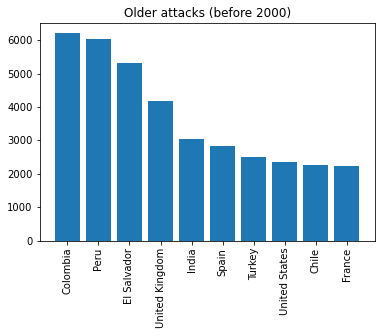

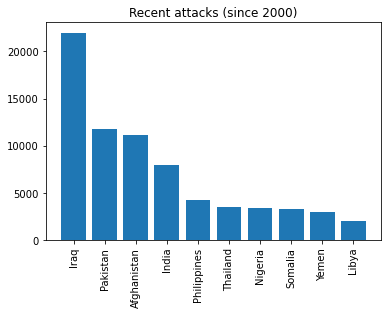

In [14]:
def show_graph(num_attacks, title):
    plt.bar(range(len(num_attacks)), num_attacks)
    plt.xticks(range(len(num_attacks)), num_attacks.index, rotation = "vertical")
    plt.title(title)
    plt.show()

show_graph(older_attacks_by_country, "Older attacks (before 2000)")
show_graph(recent_attacks_by_country, "Recent attacks (since 2000)")

We can see that these attacks definitely changed very much. First, there are many more since 2000, and second, the top targeted countries have changed a lot: only India remains in the top chart (execute the following cell if you don't believe me).

In [15]:
set(recent_attacks_by_country.index).intersection(set(older_attacks_by_country.index))

{'India'}

There's a lot more to explore in the data, but let's focus on the spatial aspect.

### Problem 6. Create a basic map (2 points)
Plot all places where terrorist attacks have occurred.

The skeleton below almost does the job. What you need to do is: first, convert the geographical coordinates to horizontal and assign them to the `x` and `y` variables; second, create a scatter plot, using a red circle (`"o"`), with marker size 1.

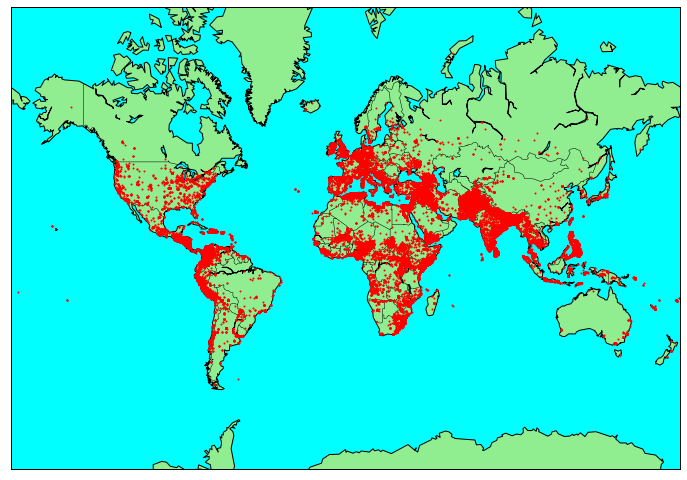

In [16]:
#defining the size of the plot
plt.figure(figsize = (12, 10))

#instantiating Basemap class object 'm' and setting up the type of projection and the coordinates
m = Basemap(projection = "merc", llcrnrlat = -73, llcrnrlon = -180, urcrnrlat = 80, urcrnrlon = 180)

# 'x' is horizontal - longitude,     'y' is vertical - latitude
#'x' and 'y' are the coordinates of the each terrorist attack
#if 'x' and 'y' are instantiated without 'm()' will have longitude/latitude coordinates
#but if they are instantiated with 'm()', then the coordinates will be
#converted to horizontal in meters
x, y = m(terrorism_data.longitude.tolist(), terrorism_data.latitude.tolist())
x, y


m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = "lightgreen", lake_color = "aqua")
m.drawmapboundary(fill_color = "aqua")

#plotting the terrorist attacks - 1 (not working properly)
#plt.scatter(x, y, s = 10, color = "yellow")

#plotting the terrorist attacks - 2
m.plot(x, y, "o", markersize = 1, color = "red")

#plot number 2 is the one, which represents the data correctly
#it is interesting how plot 1 is just showing some countours and even locations in the ocean - which is wrong

plt.show()

In [17]:
assert_is_not_none(x)
assert_is_not_none(y)


### Problem 7. Emphasize incidents which are part of a group (0 points)
Redraw the map above. This time, filter out the attacks which are part of a series (this is contained in the column `multiple`). Show them on the map with an orange color.

In [18]:
#'multiple' column has value 'True' if it's a part of a multiple incident and 'False' otherwise

#instantiating new dataframe using the criteria in the brackets - (147488, 14)
single_attacks = terrorism_data[(terrorism_data['multiple'] == False)]
single_attacks.shape

# #instantiating new dataframe using the criteria in the brackets - (22862, 14)
multiple_attacks = terrorism_data[(terrorism_data['multiple'] == True)]
multiple_attacks.shape

#check to see if the sum of the 2 datasets is equal to the initial dataset
assert(terrorism_data.shape[0] == single_attacks.shape[0] + multiple_attacks.shape[0])

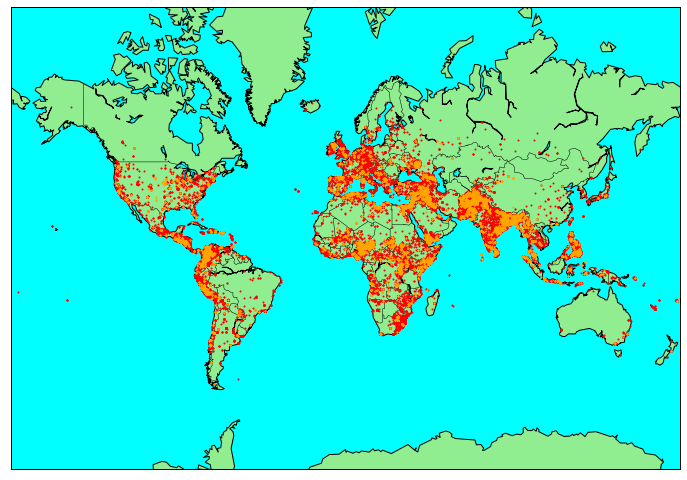

In [19]:
plt.figure(figsize = (12, 10))
m = Basemap(projection = "merc", llcrnrlat = -73, llcrnrlon = -180, urcrnrlat = 80, urcrnrlon = 180)

x, y = m(single_attacks.longitude.tolist(), single_attacks.latitude.tolist())
m.plot(x, y, "o", markersize = 1, color = "red")

x, y = m(multiple_attacks.longitude.tolist(), multiple_attacks.latitude.tolist())
m.plot(x, y, "o", markersize = 1, color = "orange")

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = "lightgreen", lake_color = "aqua")
m.drawmapboundary(fill_color = "aqua")
plt.show()

You can see that a lot of the attacks are parts of series, possibly organized. But, remember that we have a point on the map for every single attack. If we see how many multiple attacks there are (as a fraction of the whole), we'll get about 13.4%:

In [20]:
len(multiple_attacks) / len(terrorism_data)

0.13420604637511008

The plot we made was a little misleading. We're displaying where attacks occur but we omitted the "density" of attacks: each location gets a point no matter whether there was one incident, or ten thousand in that point. 

We can try plotting the densities instead.

### Problem 8. Plot attack densities (1 point)
First, we need to filter out attacks with unknown (NaN) location. Do this and save it in the variable `attacks_with_locations`.

The following cell prints a 2D histogram (also called a heatmap) over the world map. Execute it, it should run just fine.

In [21]:
#the argument 'subset' is used to select from which columns to remove NaN values 
#(remove rows, where those columns have NaN)
attacks_with_locations = terrorism_data.dropna(subset = ['latitude', 'longitude'])

In [22]:
def plot_attack_densities(attack_data, title = "Attack densities"):
    plt.figure(figsize = (15, 10))
    m = Basemap(projection = "merc", llcrnrlat = -73, llcrnrlon = -180, urcrnrlat = 80, urcrnrlon = 180)

    # Prepare histogram bins
    num_bins = 100
    lon_bins = np.linspace(-180, 180, num_bins + 1)
    
    #before it was ->   lat_bins = np.linspace(-90, 90, num_bins + 1) , but it was prone to errors
    lat_bins = np.linspace(-89, 89, num_bins + 1)

    # Create 2D histogram values
    density, x_breaks, y_breaks = np.histogram2d(
        attack_data.latitude,
        attack_data.longitude, 
        [lat_bins, lon_bins])

    # Create the basis of the histogram - the (x, y) value pairs
    # and map them to 2D distances
    lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)
    x, y = m(lon_bins_2d, lat_bins_2d)

    m.drawcoastlines()
    m.drawcountries()
    m.pcolormesh(x, y, density)
    m.colorbar()
    plt.title(title)
    plt.show()

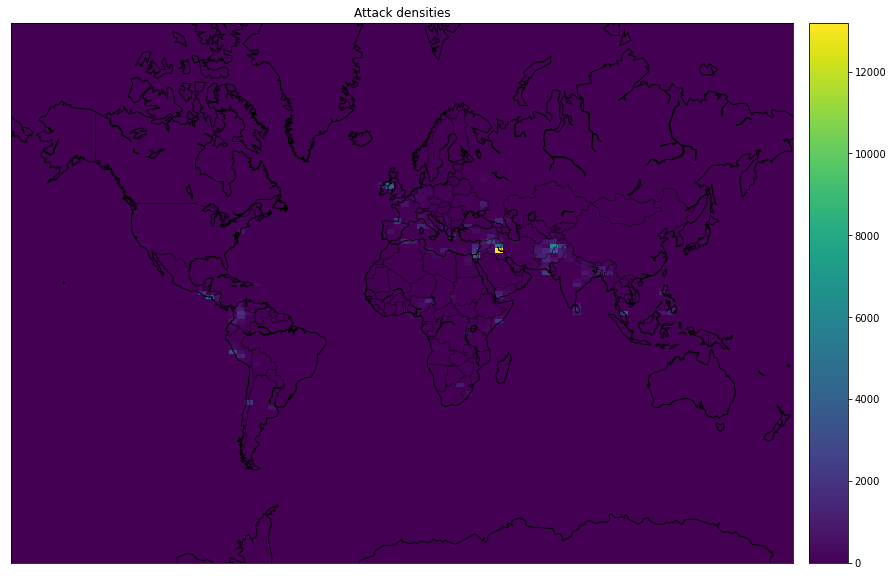

In [23]:
plot_attack_densities(attacks_with_locations)

We can see various "hot points". The hottest one, as expected from the data above, is Iraq. Actually, it has so many attacks that it overshadows most of the data in our dataset.

Let's remove it and plot the data again. This is a way to estimate **importance** of something (although not a very scientific one :)).

In [24]:
attacks_without_iraq = attacks_with_locations[attacks_with_locations['country'] != 'Iraq']

#We can see that one value is removed
len(attacks_without_iraq['country'].unique()),   len(attacks_with_locations['country'].unique())

(203, 204)

In [25]:
assert_is_not_none(attacks_with_locations)
assert_is_not_none(attacks_without_iraq)

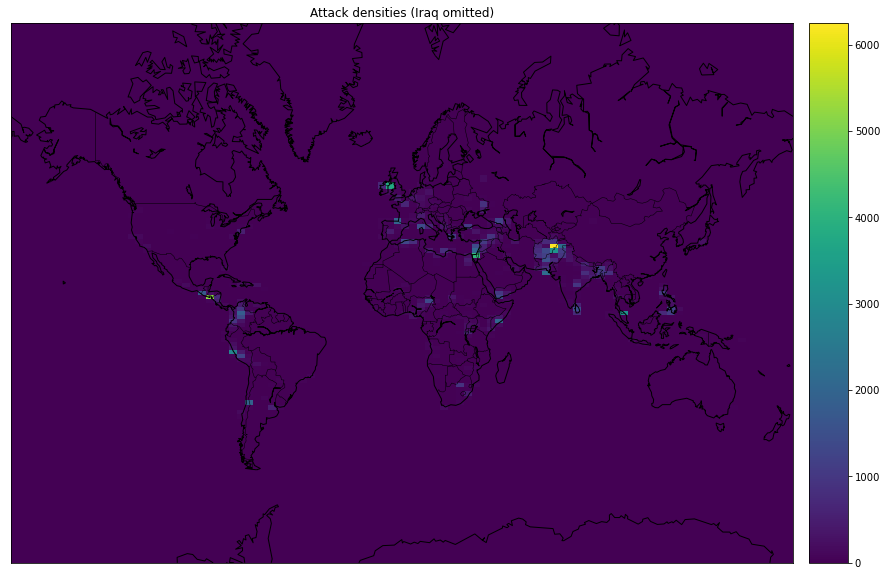

In [26]:
plot_attack_densities(attacks_without_iraq, "Attack densities (Iraq omitted)")

Well, the map "lit up". Notice that the colorbar now shows completely different values.

Based on these visualizations, we can conclude that the number of attacks in Iraq is really significant compared to all others.

We're also able to see more hot points now, and we may try to interpret them. However, that's not what we're going to do.

### Problem 9. Create a graph of connected incidents (1 + 1 points)
We already have incidents which are part of groups: the variable `multiple_attacks` holds them.

However, it turns out that some of these hold NaNs in the `related` column.

Create a new dataset which holds the `eventid` and `related` incidents of every attack in `multiple_attacks`.

Filter the dataset so that it contains only valid (i.e. non-empty or NaN) `related` values.

Store this dataset into `incident_relations`.

In [27]:
#we drop the 'NaN' values from 'related' column and take only the related column
incident_relations = multiple_attacks.dropna(subset = ['related'])[['related']]

In [28]:
assert_equal(incident_relations.shape, (22840, 1))

Get all relations by splitting the column first, like so:
```
relations = incident_relations.related.str.split(", ")
```

For each relation, if the id of the first and second node aren't the same, add the relation as an edge. An edge has the format `(id_1, id_2)`.

The code is not very hard to understand but it definitely IS tricky to write. So I'm giving it to you for free :).

In [29]:
edges = set()

relations = incident_relations.related.str.split("\D+")
for index, related in relations.iteritems():
    current_index = int(index)
    for related_id in related:
        if related_id != "":
            current_related = int(related_id)
            # (id_1, id_2) and (id_2, id_1) should be considered the same
            # undirected edge but in the dataset, they are separate
            # so we need to avoid double-adding edges
            if current_index == current_related:
                continue
            elif current_index > current_related:
                current_index, current_related = current_related, current_index
            edges.add((current_index, current_related))
print(len(edges))

16452


Create a graph, `attack_graph` and add all edges that you (or I :D) just calculated to it.

Beware: visualization will take a lot of time, so **don't do that** (or just comment it out before submitting). I'm only testing basic properties on the graph.

In [30]:
#instantiating undirected graph
attack_graph = nx.Graph(edges)

#printing the number of nodes & edges, so we would know that there is something
#since it is not advised to plot it
print(len(attack_graph.nodes), len(attack_graph.edges))


#actual plotting
#nx.draw_circular(attack_graph, with_labels = True)

#makes the plot circular
#plt.gca().set_aspect('equal')
#plt.show()

22952 16452


In [31]:
assert_is_not_none(attack_graph)